In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from tqdm import tqdm

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import warnings 
warnings.filterwarnings("ignore")

In [3]:
Amazon_df = pd.read_csv("Amazon Sale Report.csv")

## Cleaning data and Exploration

In [4]:
Amazon_df = (Amazon_df.drop_duplicates(keep='first').reset_index(drop=True)) # removed

In [5]:
Amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [6]:
Amazon_df.describe()

,index,Qty,Amount,ship-postal-code
count,128975.000000,128975.000000,121180.000000,128942.000000
mean,64487.000000,0.904431,648.561465,463966.236509
std,37232.019822,0.313354,281.211687,191476.764941
min,0.000000,0.000000,0.000000,110001.000000
25%,32243.500000,1.000000,449.000000,382421.000000
50%,64487.000000,1.000000,605.000000,500033.000000
75%,96730.500000,1.000000,788.000000,600024.000000
max,128974.000000,15.000000,5584.000000,989898.000000


In [7]:
Amazon_df.isna().sum() 

index                     0
Order ID                  0
Date                      0
Status                    0
Fulfilment                0
Sales Channel             0
ship-service-level        0
Style                     0
SKU                       0
Category                  0
Size                      0
ASIN                      0
Courier Status         6872
Qty                       0
currency               7795
Amount                 7795
ship-city                33
ship-state               33
ship-postal-code         33
ship-country             33
promotion-ids         49153
B2B                       0
fulfilled-by          89698
Unnamed: 22           49050
dtype: int64

In [8]:
# currency fillna with indian currency
Amazon_df['currency'] = Amazon_df['currency'].fillna('INR')
Amazon_df.currency.unique()

array(['INR'], dtype=object)

In [9]:
styleDf = Amazon_df.groupby('Style')['Amount'].mean()
for data in tqdm(Amazon_df[Amazon_df["Amount"].isna()].values):
    order = data[1]
    style = data[7]
    Amazon_df.loc[Amazon_df["Order ID"] == order, 'Amount'] = styleDf[style]

100%|██████████| 7795/7795 [01:02<00:00, 125.29it/s]


In [10]:
# Interquartile Range (outlier detection)
IQR = Amazon_df['Amount'].quantile(0.75) - Amazon_df['Amount'].quantile(0.25)
1.5*IQR
upper_bound = Amazon_df['Amount'].quantile(0.75) + 1.5*IQR   
lower_bound = Amazon_df['Amount'].quantile(0.25) - 1.5*IQR 

Median = Amazon_df['Amount'].median()
Amazon_df['Amount'] = Amazon_df['Amount'].apply(lambda x: Median if x > upper_bound  or x < lower_bound else x) 
Amazon_df['Amount'] = Amazon_df['Amount'].apply(lambda x: Median if x == 0 else x) 

## Analysis

### Saling by holiday

In [11]:
# Grouping the date column
Amazon_df['Date'] = pd.to_datetime(Amazon_df['Date'])
daily_sales = Amazon_df.groupby('Date').agg(total_qty=('Qty', 'sum'), total_amount=('Amount', 'sum')).reset_index()
daily_sales

,Date,total_qty,total_amount
0,2022-03-31,156,1.070643e+05
1,2022-04-01,1319,9.257107e+05
2,2022-04-02,1408,9.748835e+05
3,2022-04-03,1544,1.073058e+06
4,2022-04-04,1331,9.267426e+05
...,...,...,...
86,2022-06-25,940,6.796442e+05
87,2022-06-26,1122,7.951961e+05
88,2022-06-27,1023,7.466875e+05
89,2022-06-28,1104,8.100987e+05


In [12]:
in_holidays = list(holidays.IN(years=[2022, 2023]))
in_holidays = daily_sales[daily_sales['Date'].isin(in_holidays)]

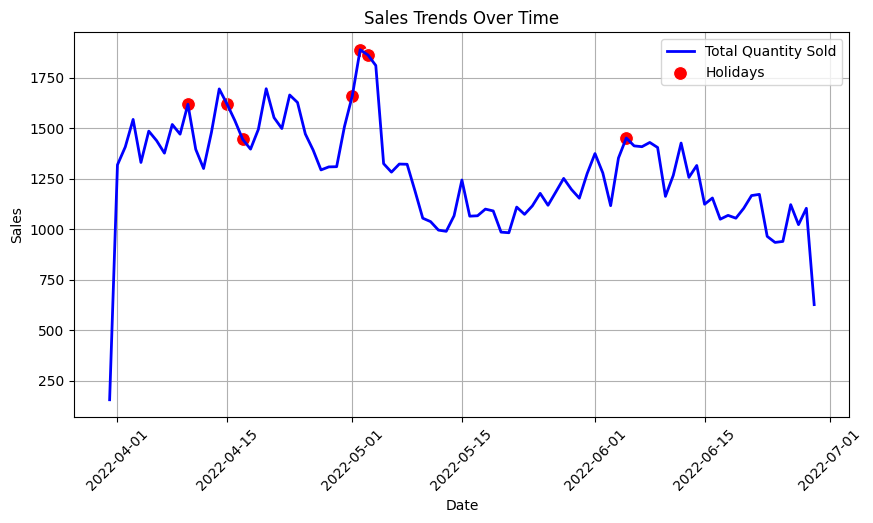

In [13]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_sales, x='Date', y='total_qty', label='Total Quantity Sold', color='blue', linewidth=2)
sns.scatterplot(data=in_holidays,  x='Date', y='total_qty', color='red', s=100, label='Holidays')

plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)  
plt.legend()
plt.grid(True)
plt.show()

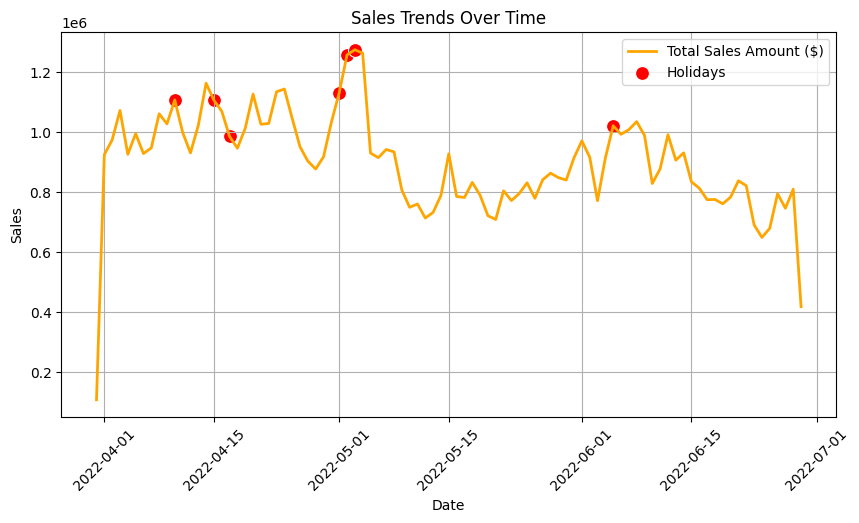

In [14]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_sales, x='Date', y='total_amount', label='Total Sales Amount ($)', color='orange', linewidth=2)
sns.scatterplot(data=in_holidays,  x='Date', y='total_amount', color='red', s=100, label='Holidays')

plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)  
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Nearest holiday
differences = abs(daily_sales['Date'].values[:, None] - in_holidays["Date"].values)
nearest_indices = np.argmin(differences, axis=1)
daily_sales["nearest_holiday"] = in_holidays['Date'].iloc[nearest_indices].values
daily_sales["nearest_holiday_day"] = (daily_sales["Date"] - daily_sales["nearest_holiday"]).dt.days
daily_sales

,Date,total_qty,total_amount,nearest_holiday,nearest_holiday_day
0,2022-03-31,156,1.070643e+05,2022-04-10,-10
1,2022-04-01,1319,9.257107e+05,2022-04-10,-9
2,2022-04-02,1408,9.748835e+05,2022-04-10,-8
3,2022-04-03,1544,1.073058e+06,2022-04-10,-7
4,2022-04-04,1331,9.267426e+05,2022-04-10,-6
...,...,...,...,...,...
86,2022-06-25,940,6.796442e+05,2022-06-05,20
87,2022-06-26,1122,7.951961e+05,2022-06-05,21
88,2022-06-27,1023,7.466875e+05,2022-06-05,22
89,2022-06-28,1104,8.100987e+05,2022-06-05,23


In [16]:
def categorize_sales(date):
    """+7 days before holiday, -7 days after holiday, otherwise normal"""
    if date == 0:
        return 'Holiday'
    elif date >= -7 and date < 0 :
        return '1 week Before Holiday'
    elif date > 0 and date <= 7:
        return '1 week After Holiday'
    else:
        return 'Normal'

daily_sales['Holiday_Status'] = daily_sales['nearest_holiday_day'].apply(categorize_sales)
daily_sales

,Date,total_qty,total_amount,nearest_holiday,nearest_holiday_day,Holiday_Status
0,2022-03-31,156,1.070643e+05,2022-04-10,-10,Normal
1,2022-04-01,1319,9.257107e+05,2022-04-10,-9,Normal
2,2022-04-02,1408,9.748835e+05,2022-04-10,-8,Normal
3,2022-04-03,1544,1.073058e+06,2022-04-10,-7,1 week Before Holiday
4,2022-04-04,1331,9.267426e+05,2022-04-10,-6,1 week Before Holiday
...,...,...,...,...,...,...
86,2022-06-25,940,6.796442e+05,2022-06-05,20,Normal
87,2022-06-26,1122,7.951961e+05,2022-06-05,21,Normal
88,2022-06-27,1023,7.466875e+05,2022-06-05,22,Normal
89,2022-06-28,1104,8.100987e+05,2022-06-05,23,Normal


In [17]:
sales_by_holiday = daily_sales.groupby('Holiday_Status').agg(mean_qty=('total_qty', 'mean'),mean_amount=('total_amount', 'mean')).reset_index()
sales_by_holiday.sort_values(by='mean_qty', ascending=False, inplace=True)

In [18]:
# Create a subplot figure with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("mean Amount/Day by Holiday Status", "mean Amount/Day Quantity by Holiday Status"))

# Add the first bar plot for 'total_amount' in the first column
fig.add_trace(
    go.Bar(
        x=sales_by_holiday['Holiday_Status'],
        y=sales_by_holiday['mean_amount'],
        name='Mean Amount',
        marker_color='#FFA0A4'  # Color for total_amount bars
    ),
    row=1, col=1
)

# Add the second bar plot for 'total_qty' in the second column
fig.add_trace(
    go.Bar(
        x=sales_by_holiday['Holiday_Status'],
        y=sales_by_holiday['mean_qty'],
        name='Mean Quantity'
    ),
    row=1, col=2
)
# Update layout
fig.update_layout(
    title='Sales Performance: Normal, Before, During, and After Holidays',
    height=600
)

# Show the combined plot
fig.show()


During holidays, people tend to shop the most. The period after holidays ranks second, followed by the period before holidays. Therefore, it is advisable to prepare e-commerce inventory at least one week before the holiday period.

ช่วงวันหยุดเป็นช่วงที่คนมาซื้อของมากที่สุด หลังจากวันหยุดเป็นอันดับที่ 2 ก่อนวันหยุดเป็นอันดับที่ 3 ฉะนั้นควรเตรียมสินค้าใน e-commerce ก่อนถึงช่วงใกล้วันหยุด 1 อาทิตย์

### Saling by day_name

In [19]:
daily_sales['Day_of_Week'] = daily_sales['Date'].dt.day_name()
sales_by_days = daily_sales.groupby('Day_of_Week').agg(mean_qty=('total_qty', 'mean'),mean_amount=('total_amount', 'mean')).reset_index()
week_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Set the 'day_name' column to have this categorical order
sales_by_days['Day_of_Week'] = pd.Categorical(sales_by_days['Day_of_Week'], categories=week_order, ordered=True)
# Sort the DataFrame by the 'day_name' column
sales_by_days = sales_by_days.sort_values('Day_of_Week').reset_index(drop=True)

In [20]:
# Create a subplot figure with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Mean Amount/Day by Holiday Status", "Mean Quantity/Day by Holiday Status"))

# Add the first bar plot for 'total_amount' in the first column
fig.add_trace(
    go.Bar(
        x=sales_by_days['Day_of_Week'],
        y=sales_by_days['mean_amount'],
        name='Mean Amount',
        marker_color='#FFA0A4'  # Color for total_amount bars
    ),
    row=1, col=1
)

# Add the second bar plot for 'total_qty' in the second column
fig.add_trace(
    go.Bar(
        x=sales_by_days['Day_of_Week'],
        y=sales_by_days['mean_qty'],
        name='Mean Quantity'
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title='Sales Performance: Normal, Before, During, and After Holidays',
    height=600
)

# Show the combined plot
fig.show()

During holidays, the highest number of products are sold, and the highest sales amount is achieved. On the other hand, Thursday has the lowest number of products sold and the lowest sales amount.

### Saling price amount per count of order

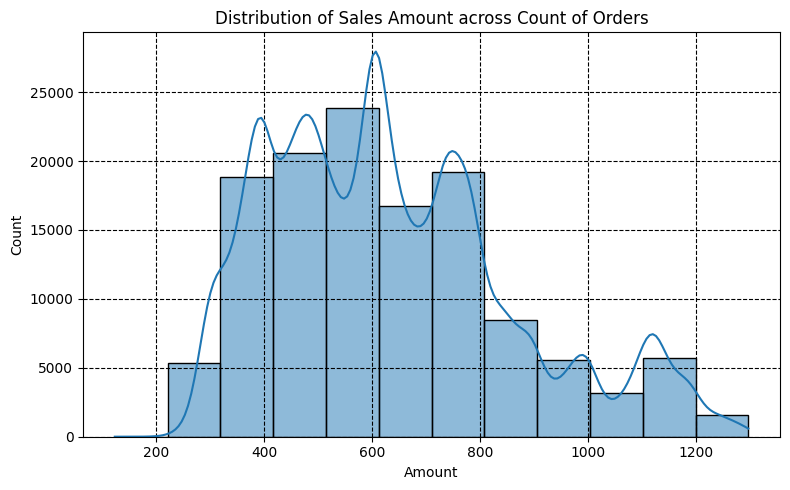

In [21]:
fig, my_ax = plt.subplots(figsize=(8,5))

sns.histplot(data = Amazon_df['Amount'], ax=my_ax, binwidth=100, kde=True)
plt.grid(linestyle='--',color='#000000')
plt.title("Distribution of Sales Amount across Count of Orders")
plt.tight_layout()

The most suitable price range is between 400-600 Rupees.


### top 5 most selling product in Amazon

In [22]:
Top5_Trending_product=Amazon_df.groupby('Category')['Amount'].sum().to_frame().sort_values(by=['Amount'],ascending=False).head(5)
Top5_Trending_product

,Amount
Category,
Set,3.949656e+07
kurta,2.320868e+07
Western Dress,1.191052e+07
Top,5.687990e+06
Ethnic Dress,8.448830e+05


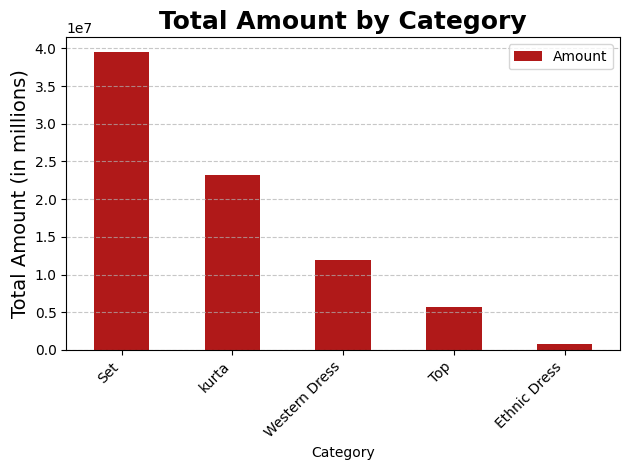

In [23]:
Top5_Trending_product.plot(kind='bar',color='#b01919')
plt.title('Total Amount by Category', fontsize=18, weight='bold')
plt.ylabel('Total Amount (in millions)', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

The five best-selling products are Set, Kurta, Western Dress, Top, and Ethnic Dress. Therefore, it is essential to consistently keep these items well-stocked in the warehouse.

### Top 5 cities order from Amazon

In [24]:
Top5_cities_orderfrom_Amazon=Amazon_df.groupby('ship-city')['Amount'].sum().to_frame().sort_values(by=['Amount'],ascending=False).head(5)

In [25]:
Top5_cities_orderfrom_Amazon

,Amount
ship-city,
BENGALURU,7.069377e+06
HYDERABAD,5.134185e+06
MUMBAI,3.819661e+06
NEW DELHI,3.794739e+06
CHENNAI,3.232176e+06


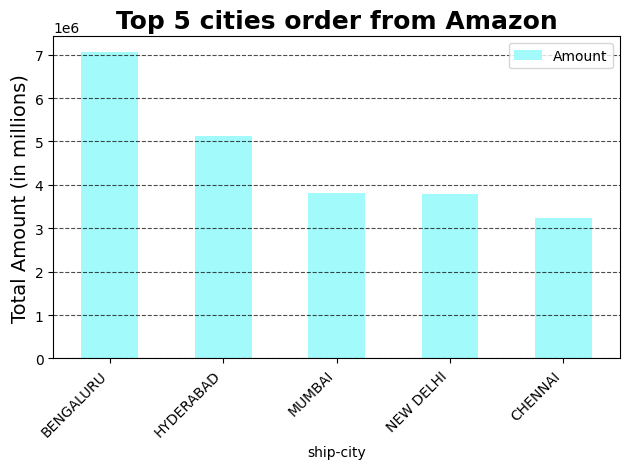

In [26]:
Top5_cities_orderfrom_Amazon.plot(kind='bar',color='#a3fafb')
plt.title('Top 5 cities order from Amazon', fontsize=18, weight='bold')
plt.ylabel('Total Amount (in millions)', fontsize=14)
plt.grid(True, axis='y', linestyle='--',color='#000000', alpha=0.7)
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

The five cities that frequently order our products are Bengaluru, Hyderabad, Mumbai, New Delhi, and Chennai. It would be wise to consider setting up distribution centers in these areas.

In [27]:
Total_Qty_ordered = Amazon_df['Qty'].sum()

In [28]:
Total_Sales = Amazon_df['Amount'].sum()

In [29]:
Sales_Order_wise = Amazon_df.groupby('Order ID').agg({'Qty': 'count', 'Amount': 'sum', 'Status': 'sum', 'Fulfilment': 'sum', 'ship-service-level': 'sum', 'ship-service-level': 'sum', 'Style': 'sum', 'SKU': 'sum', 'Category': 'sum', 'ship-city': 'sum', 'ship-state': 'sum', 'B2B': 'sum', 'promotion-ids': 'sum'})

In [30]:
Sales_Order_wise

,Qty,Amount,Status,Fulfilment,ship-service-level,Style,SKU,Category,ship-city,ship-state,B2B,promotion-ids
Order ID,,,,,,,,,,,,
171-0000547-8192359,1,301.000000,Shipped,Amazon,Expedited,JNE2032,JNE2032-KR-205-XL,kurta,PIMPRI CHINCHWAD,MAHARASHTRA,0,0
171-0000902-4490745,1,544.000000,Cancelled,Amazon,Expedited,J0097,J0097-KR-M,kurta,Howrah,WEST BENGAL,0,0
171-0001409-6228339,1,422.000000,Shipped,Amazon,Expedited,JNE3440,JNE3440-KR-N-XS,kurta,KODAD,TELANGANA,0,0
171-0003082-5110755,1,563.000000,Shipped,Amazon,Expedited,SET291,SET291-KR-PP-L,Set,GREATER NOIDA,UTTAR PRADESH,0,0
171-0003738-2052324,1,379.000000,Shipped,Amazon,Expedited,JNE3440,JNE3440-KR-N-XS,kurta,FIROZABAD,UTTAR PRADESH,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
S02-9578181-3610412,1,756.778688,Shipped,Amazon,Standard,SET197,SET197-KR-NP-S,Set,Surat,Gujarat,0,0
S02-9599483-2736812,1,1130.585074,Shipping,Amazon,Standard,J0012,J0012-SKD-L,Set,Surat,Gujarat,0,0
S02-9649067-3246849,1,450.434748,Shipped,Amazon,Standard,JNE3291,JNE3291-KR-L,kurta,Surat,Gujarat,0,0


In [31]:
Top5_seller_by_qt=Sales_Order_wise.sort_values(by='Qty', ascending = False).head(5)

In [32]:
Top5_seller_by_qt

,Qty,Amount,Status,Fulfilment,ship-service-level,Style,SKU,Category,ship-city,ship-state,B2B,promotion-ids
Order ID,,,,,,,,,,,,
171-5057375-2831560,12,6227.62,CancelledCancelledCancelledCancelledCancelledC...,MerchantMerchantMerchantMerchantMerchantMercha...,StandardStandardStandardStandardStandardStanda...,J0210JNE3628JNE3476J0150JNE3786SET147SET288J01...,J0210-DR-XXXLJNE3628-KR-XXXLJNE3476-KR-XXLJ015...,Ethnic DresskurtakurtakurtakurtaSetSetTopkurta...,CHENNAICHENNAICHENNAICHENNAICHENNAICHENNAICHEN...,TAMIL NADUTAMIL NADUTAMIL NADUTAMIL NADUTAMIL ...,0,0
403-4984515-8861958,12,5923.00,ShippedShippedShippedShippedShippedShippedShip...,AmazonAmazonAmazonAmazonAmazonAmazonAmazonAmaz...,ExpeditedExpeditedExpeditedExpeditedExpeditedE...,JNE3792JNE3764JNE3503J0308JNE3702JNE3741JNE363...,JNE3792-KR-XXXLJNE3764-KR-XXXLJNE3503-KR-XXXLJ...,kurtakurtakurtaWestern DresskurtakurtakurtaSet...,SOLAPURSOLAPURSOLAPURSOLAPURSOLAPURSOLAPURSOLA...,MAHARASHTRAMAHARASHTRAMAHARASHTRAMAHARASHTRAMA...,0,IN Core Free Shipping 2015/04/08 23-48-5-108IN...
404-9932919-6662730,11,5789.00,Shipped - Delivered to BuyerShipped - Delivere...,MerchantMerchantMerchantMerchantMerchantMercha...,StandardStandardStandardStandardStandardStanda...,JNE3548JNE2100JNE3440JNE3630JNE3628SET184JNE36...,JNE3548-KR-XSJNE2100-KR-144-XSJNE3440-KR-N-XSJ...,kurtakurtakurtakurtakurtaSetkurtaSetSetSetkurta,PUNEPUNEPUNEPUNEPUNEPUNEPUNEPUNEPUNEPUNEPUNE,MAHARASHTRAMAHARASHTRAMAHARASHTRAMAHARASHTRAMA...,0,Amazon PLCC Free-Financing Universal Merchant ...
403-0173977-3041148,11,5976.00,Shipped - Delivered to BuyerShipped - Delivere...,MerchantMerchantMerchantMerchantMerchantMercha...,StandardStandardStandardStandardStandardStanda...,JNE3869JNE3720JNE3273JNE3738JNE3739JNE3861SET2...,JNE3869-DR-XXXLJNE3720-KR-XXXLJNE3273-KR-XXXLJ...,Western DresskurtakurtakurtakurtaWestern Dress...,SOLAPURSOLAPURSOLAPURSOLAPURSOLAPURSOLAPURSOLA...,MAHARASHTRAMAHARASHTRAMAHARASHTRAMAHARASHTRAMA...,0,Amazon PLCC Free-Financing Universal Merchant ...
408-3317403-1729937,10,5986.00,Shipped - Delivered to BuyerShipped - Delivere...,MerchantMerchantMerchantMerchantMerchantMercha...,StandardStandardStandardStandardStandardStanda...,JNE3437JNE3753JNE3787SET288JNE3726SET048SET220...,JNE3437-KR-XXXLJNE3753-KR-XXXLJNE3787-KR-XXXLS...,kurtakurtakurtaSetkurtaSetSetSetSetkurta,HYDERABADHYDERABADHYDERABADHYDERABADHYDERABADH...,TELANGANATELANGANATELANGANATELANGANATELANGANAT...,0,Amazon PLCC Free-Financing Universal Merchant ...


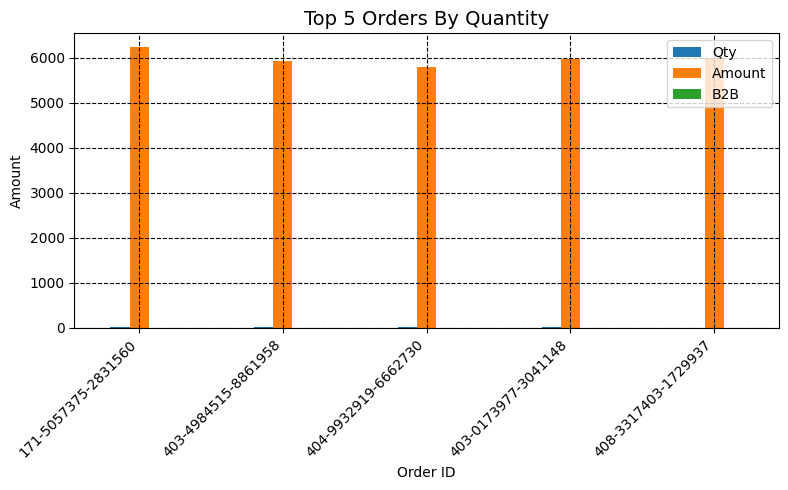

In [33]:
_, my_ax = plt.subplots(figsize=(8, 5))
Top5_seller_by_qt.plot(kind='bar', ax=my_ax, width=0.4)
plt.xticks(rotation=1, fontsize=10)
plt.grid(linestyle='--',color='#000000')
plt.title("Top 5 Orders By Quantity", fontsize=14)
plt.ylabel("Amount")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

In [34]:
Top5_orderby_amount=Sales_Order_wise.sort_values(by='Amount', ascending = False).head(5)


In [35]:
Top5_orderby_amount

,Qty,Amount,Status,Fulfilment,ship-service-level,Style,SKU,Category,ship-city,ship-state,B2B,promotion-ids
Order ID,,,,,,,,,,,,
407-0717613-4338735,6,6749.275862,ShippedShippedShippedShippedShippedShipped,AmazonAmazonAmazonAmazonAmazonAmazon,ExpeditedExpeditedExpeditedExpeditedExpeditedE...,J0004J0009J0007JNE3463J0012J0008,J0004-SKD-LJ0009-SKD-LJ0007-SKD-LJNE3463-KR-LJ...,SetSetSetkurtaSetSet,MUMBAIMUMBAIMUMBAIMUMBAIMUMBAIMUMBAI,MAHARASHTRAMAHARASHTRAMAHARASHTRAMAHARASHTRAMA...,0,0
406-9002076-4152331,9,6509.000000,Shipped - Delivered to BuyerShipped - Delivere...,MerchantMerchantMerchantMerchantMerchantMercha...,StandardStandardStandardStandardStandardStanda...,J0308J0302SET324J0338JNE3870SET267J0339J0295J0341,J0308-DR-XXXLJ0302-DR-XXLSET324-KR-NP-XXXLJ033...,Western DressWestern DressSetWestern DressWest...,HYDERABADHYDERABADHYDERABADHYDERABADHYDERABADH...,TELANGANATELANGANATELANGANATELANGANATELANGANAT...,0,Amazon PLCC Free-Financing Universal Merchant ...
171-0706521-2133101,9,6313.000000,Shipped - Delivered to BuyerShipped - Delivere...,MerchantMerchantMerchantMerchantMerchantMercha...,StandardStandardStandardStandardStandardStanda...,JNE3605SET058SET217JNE3440SET094SET233SET396JN...,JNE3605-KR-XXLSET058-KR-NP-XXLSET217-KR-PP-XXL...,kurtaSetSetkurtaSetSetSetkurtaSet,HYDERABADHYDERABADHYDERABADHYDERABADHYDERABADH...,TELANGANATELANGANATELANGANATELANGANATELANGANAT...,0,Amazon PLCC Free-Financing Universal Merchant ...
403-9984530-4477124,7,6268.000000,ShippedShippedShippedShippedShippedShippedShipped,AmazonAmazonAmazonAmazonAmazonAmazonAmazon,ExpeditedExpeditedExpeditedExpeditedExpeditedE...,SET269SET268J0008JNE3463SET264J0005J0283,SET269-KR-NP-XLSET268-KR-NP-XLJ0008-SKD-XLJNE3...,SetSetSetkurtaSetWestern DressSet,"Ranip,AHMEDABADRanip,AHMEDABADRanip,AHMEDABADR...",GujaratGujaratGujaratGujaratGujaratGujaratGujarat,0,IN Core Free Shipping 2015/04/08 23-48-5-108IN...
171-5057375-2831560,12,6227.620000,CancelledCancelledCancelledCancelledCancelledC...,MerchantMerchantMerchantMerchantMerchantMercha...,StandardStandardStandardStandardStandardStanda...,J0210JNE3628JNE3476J0150JNE3786SET147SET288J01...,J0210-DR-XXXLJNE3628-KR-XXXLJNE3476-KR-XXLJ015...,Ethnic DresskurtakurtakurtakurtaSetSetTopkurta...,CHENNAICHENNAICHENNAICHENNAICHENNAICHENNAICHEN...,TAMIL NADUTAMIL NADUTAMIL NADUTAMIL NADUTAMIL ...,0,0


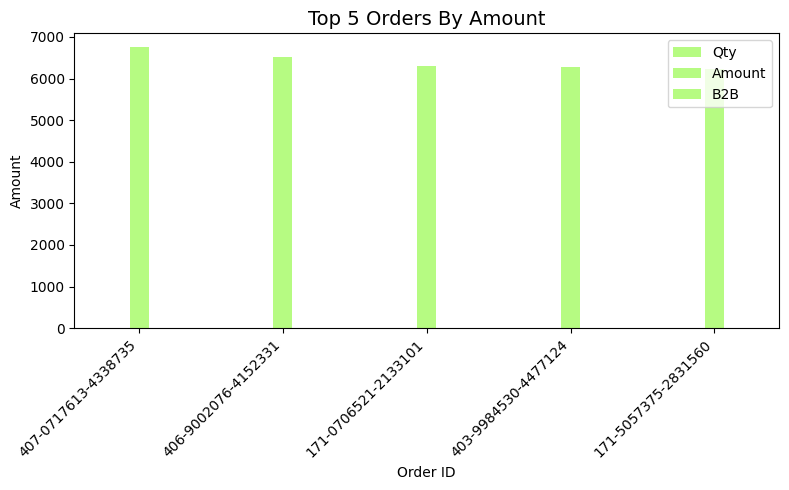

In [36]:
_, my_ax = plt.subplots(figsize=(8, 5))
Top5_orderby_amount.plot(kind='bar', ax=my_ax, width=0.4,color='#b6fb82')
plt.xticks(rotation=1, fontsize=10)
#plt.grid(color='#000000')
plt.title("Top 5 Orders By Amount", fontsize=14)
plt.ylabel("Amount")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

In [37]:
Amazon_df['Year'] = pd.DatetimeIndex(Amazon_df['Date']).year
Amazon_df['Month'] = pd.DatetimeIndex(Amazon_df['Date']).month

In [38]:
Orders_date_wise = Amazon_df.groupby('Date').agg({'Qty': 'count', 'Amount': 'sum'}).sort_values(by='Amount', ascending = False).head(5)


In [39]:
Orders_date_wise

,Qty,Amount
Date,,
2022-05-03,2085,1.275930e+06
2022-05-04,2015,1.264548e+06
2022-05-02,2079,1.258622e+06
2022-04-14,1883,1.164142e+06
2022-04-24,1810,1.144748e+06


In [40]:
Orders_qt=Amazon_df.groupby('Date').agg({'Qty': 'count', 'Amount': 'sum'}).sort_values(by='Qty', ascending = False).head(5)

In [41]:
Orders_qt

,Qty,Amount
Date,,
2022-05-03,2085,1.275930e+06
2022-05-02,2079,1.258622e+06
2022-05-04,2015,1.264548e+06
2022-04-14,1883,1.164142e+06
2022-04-15,1853,1.107090e+06


In [42]:
order_status=Amazon_df.groupby('Status').agg({'Qty': 'count', 'Amount': 'sum'}).sort_values(by='Qty', ascending = False)

In [43]:
order_status

,Qty,Amount
Status,,
Shipped,77804,4.942066e+07
Shipped - Delivered to Buyer,28769,1.836371e+07
Cancelled,18332,1.149928e+07
Shipped - Returned to Seller,1953,1.246176e+06
Shipped - Picked Up,973,6.487440e+05
Pending,658,4.199523e+05
Pending - Waiting for Pick Up,281,1.910750e+05
Shipped - Returning to Seller,145,1.023580e+05
Shipped - Out for Delivery,35,2.380700e+04


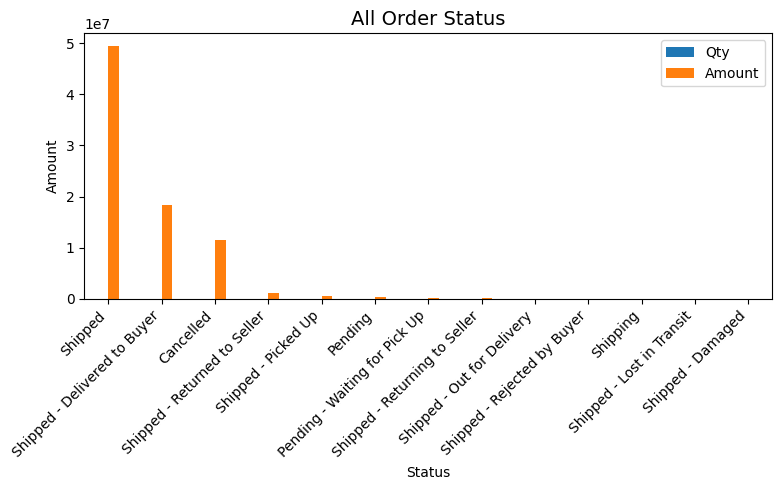

In [44]:
_, my_ax = plt.subplots(figsize=(8, 5))
order_status.plot(kind='bar', ax=my_ax, width=0.4)
plt.xticks(rotation=1, fontsize=10)
#plt.grid()
plt.title("All Order Status", fontsize=14)
plt.ylabel("Amount")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

### Saling by mounth

In [49]:
Sales_month_wise = Amazon_df.groupby('Month').agg({'Amount': 'sum', 'Qty': 'sum'})
Sales_month_wise = Sales_month_wise[1:] # remove the first row as it is not a complete month
Sales_month_wise

,Amount,Qty
Month,,
4,3.041243e+07,44206
5,2.705543e+07,38011
6,2.435970e+07,34276


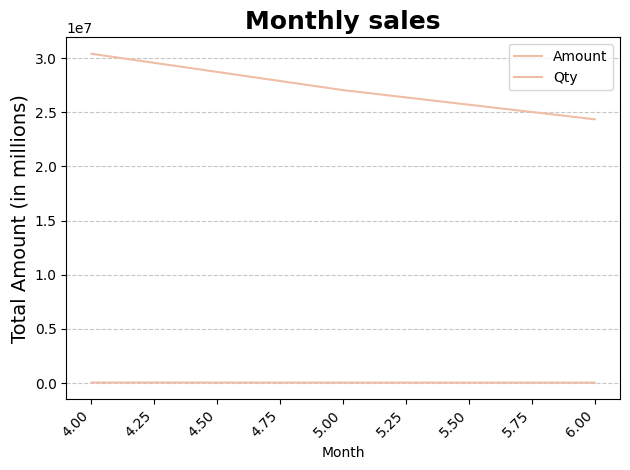

In [50]:
Sales_month_wise.plot(kind='line',color='#f0bda7')
plt.title('Monthly sales', fontsize=18, weight='bold')
plt.ylabel('Total Amount (in millions)', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


Why did sales drop in May and June?

### Saling pecentage of fulfilment

In [47]:
Sales_percentage_by_fulfilment = (Amazon_df.groupby('Fulfilment').agg({'Qty': 'count', 'Amount': 'sum'}).sort_values(by='Amount', ascending = False)['Amount']/81352807.57)*100
Sales_percentage_by_fulfilment

Fulfilment
Amazon      69.989977
Merchant    30.725194
Name: Amount, dtype: float64

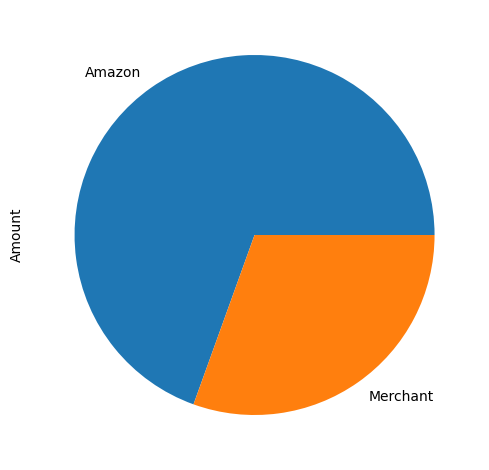

In [48]:
Sales_percentage_by_fulfilment.plot(kind='pie')
plt.tight_layout()

Methond of fulfillment 70% by Amazon and other a merchant.This point show that people trust in amazon